<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Ripples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl
!pip install XlsxWriter


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 5.4 MB/s eta 0:00:00


In [2]:
!pip install --upgrade pyabf
import pyabf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 3.0 MB/s eta 0:00:00


In [3]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    # if not( os.path.exists(new_filename_stripped)):
    !echo A | unzip $zipped_file_path -d $unzipped_file_path
    return new_filename

In [4]:
data_source = "https://www.dropbox.com/sh/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a?dl=0"
data_name = '_today'

file_loc = get_drobox_folder(data_source, 'my_ephys_data_' + data_name)

--2023-06-29 23:21:06--  https://www.dropbox.com/sh/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a [following]
--2023-06-29 23:21:06--  https://www.dropbox.com/sh/raw/5vbxypqs4cmpp30/AABjnr27ry8GrcloIOFItBf5a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc064f2fd9475a9a22c0e63da1a0.dl.dropboxusercontent.com/zip_download_get/BiU0QRufTVl6fh87l1qfngIUbK0Um3W1MqKc9zMB9ywYl-dvqeWXCUTSu1rIK7IuMO33oqkicwJlttlXxREuLdPuKIByHjPOatZ-B8wa4gn7bA# [following]
--2023-06-29 23:21:07--  https://uc064f2fd9475a9a22c0e63da1a0.dl.dropboxusercontent.com/zip_download_get/BiU0QRufTVl6fh87l1qfngIUbK0Um3W1MqKc9zMB9ywYl-dvqeWXCUTSu1rIK7IuMO33oqkicwJlttlXxREuLdPuKIBy

In [8]:
my_abf = pyabf.ABF('/content/my_ephys_data__today/2023x06x29_E3KI_F_P318_s004_0002.abf')

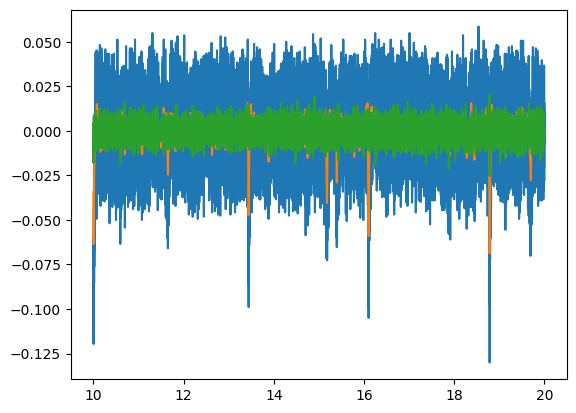

In [35]:
in0 = my_abf.sweepY
time = my_abf.sweepX


fig,ax=plt.subplots()


t_condit = np.logical_and(time>10,time<20)

sub_y = in0[t_condit]
sub_x = time[t_condit]

ax.plot(sub_x,sub_y)

b, a = scipy.signal.butter(2, [4,60], btype='bandpass',fs=10000)
y_filt = scipy.signal.filtfilt(b, a, sub_y)
ax.plot(sub_x,y_filt)

b, a = scipy.signal.butter(2, [60,250], btype='bandpass',fs=10000)
y_filt = scipy.signal.filtfilt(b, a, sub_y)
ax.plot(sub_x,y_filt)


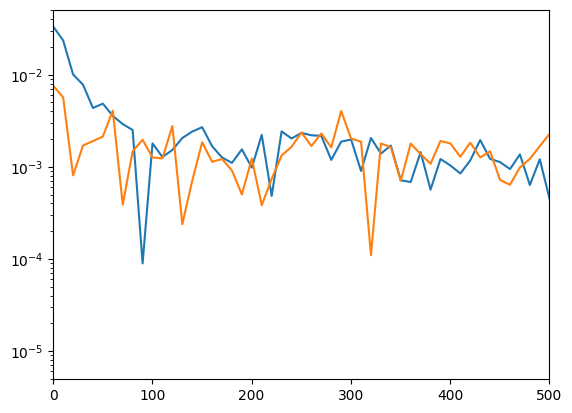

In [19]:
from scipy.fft import fft, fftfreq

N = len(sub_x)
T = 1/10000

yf = fft(sub_y)
xf = fftfreq(N, T)[:N//2]

import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.grid()
ax.set_xlim(0,500)
ax.set_yscale('log')

prerip_t_condit = np.logical_and(time-.1>13.4,time-.1<13.5)
yf = fft(in0[prerip_t_condit])
ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
ax.grid()
ax.set_xlim(0,500)
ax.set_yscale('log')

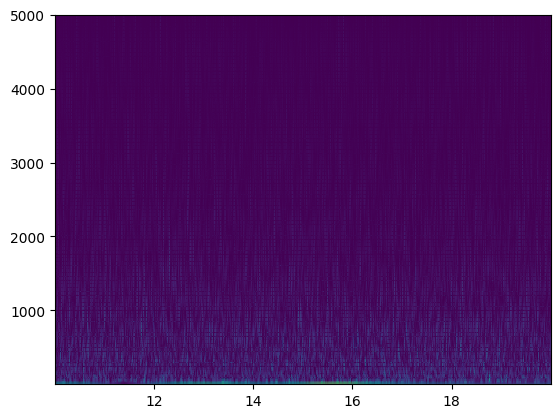

In [37]:
from scipy import signal
fs = 10000
w = 6.



freq = np.linspace(1, fs/2, 100)
widths = w*fs / (2*freq*np.pi)
cwtm = signal.cwt(sub_y, signal.morlet2, widths, w=w)
plt.pcolormesh(sub_x, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
plt.show()